# Modelado v1.2 – Notas de Actividades
Replica **v1.2** pero usando únicamente las columnas de notas de las tareas y la variable global `nota_media`. Todas las *features* se estandarizan antes del modelado.

## 0. Librerías

In [5]:

# Core
import pandas as pd
import numpy as np
import os, joblib, matplotlib.pyplot as plt

# Scikit‑learn
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Red neuronal
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer


# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


## 1. Carga y preparación de los datos

In [ ]:

DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'
MODEL_PATH = 'models_v1.2'
os.makedirs(MODEL_PATH, exist_ok=True)

df = pd.read_parquet(f'{DATA_PATH}/dataset_2.0.parquet')

# Seleccionar sólo columnas de notas de actividades (contienen '(nota)' pero no empiezan con 'Clase')
grade_cols = [c for c in df.columns if '(nota)' in c and not c.startswith('Clase')]
df = df[['userid', 'abandona'] + grade_cols]

# Métrica global: nota_media
df['nota_media'] = df[grade_cols].mean(axis=1)

# Guardar dataset filtrado
df.to_parquet(f'{DATA_PATH}/dataset_1.2.parquet')

# Split
X = df.drop(columns=['userid', 'abandona'])
y = df['abandona']

display(df.head())
print('Shape X:', X.shape)

display(X.head())


,userid,abandona,Test Expr. (nota),Test Complejidad (nota),Act. 02 - Elecciones (nota),Act. 03 - Catalan (nota),Act. 04 - Primos (nota),Act. 05 - Vectores (nota),Act. 07 (nota),nota_media
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,0,10.0,5.00000,10.0,7.0,10.0,NaN,8.50,8.416667
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,0,10.0,6.00000,10.0,10.0,10.0,10.0,6.25,8.892857
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,10.0,8.66667,10.0,10.0,9.0,5.0,6.00,8.380953
3,b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bd...,0,10.0,7.33333,10.0,10.0,10.0,10.0,10.00,9.619047
4,fd96e32a94a932f45eb32933d9ffeb71f4addf9153a76b...,0,6.0,6.00000,10.0,10.0,NaN,10.0,0.00,7.000000


Shape X: (201, 8)


,Test Expr. (nota),Test Complejidad (nota),Act. 02 - Elecciones (nota),Act. 03 - Catalan (nota),Act. 04 - Primos (nota),Act. 05 - Vectores (nota),Act. 07 (nota),nota_media
0,10.0,5.00000,10.0,7.0,10.0,NaN,8.50,8.416667
1,10.0,6.00000,10.0,10.0,10.0,10.0,6.25,8.892857
2,10.0,8.66667,10.0,10.0,9.0,5.0,6.00,8.380953
3,10.0,7.33333,10.0,10.0,10.0,10.0,10.00,9.619047
4,6.0,6.00000,10.0,10.0,NaN,10.0,0.00,7.000000


## 2. Preprocesador y generador de pipelines

In [6]:
# --- 0) Imports necesarios (añade esto si no está arriba) ------------


# --- 1) Función nombrada en lugar de lambda --------------------------
def replace_minus_one(X):
    """
    Reemplaza todos los -1 en el array por 0.
    (X puede ser DataFrame o ndarray)
    """
    X_arr = np.array(X, copy=True)
    X_arr[X_arr == -1] = 0
    return X_arr

# --- 2) Construcción del preprocesador numérico ----------------------
num_pipeline = Pipeline([
    ("minus1_to_0", FunctionTransformer(replace_minus_one,
                                        feature_names_out="one-to-one")),
    ("impute_0",    SimpleImputer(strategy="constant", fill_value=0)),
    ("scale",       StandardScaler())
])

# Ahora aplicamos este pipeline a TODAS las columnas numéricas
preprocessor = ColumnTransformer(
    [("num", num_pipeline, X.columns)],
    remainder="drop"
)

# --- 3) Generador de pipelines de modelos (celda 3 modificada) --------
def make_pipeline(name, use_smote=False):
    if name == "LogReg":
        clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    elif name == "Tree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
    elif name == "XGB":
        ratio = y.value_counts()[0] / y.value_counts()[1]
        clf = XGBClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=ratio, eval_metric="logloss",
            random_state=42
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE()))
    steps.append(("clf", clf))

    pipe = ImbPipeline(steps) if use_smote else Pipeline(steps)
    fname = os.path.join(MODEL_PATH, f"{name.lower()}{'_smote' if use_smote else ''}.pkl")
    return pipe, fname


## 3. Evaluación y guardado de modelos clásicos

In [8]:

scoring = ['f1', 'roc_auc', 'precision', 'recall']

def evaluate_and_save(name, use_smote=False):
    pipe, fname = make_pipeline(name, use_smote)
    cvres = cross_validate(pipe, X, y, cv=5, scoring=scoring, n_jobs=-1)
    metrics = {m: (cvres[f'test_{m}'].mean(), cvres[f'test_{m}'].std()) for m in scoring}
    pipe.fit(X, y)
    joblib.dump(pipe, fname)
    return {'model': f"{name}{'+SMOTE' if use_smote else ''}", **metrics}

results = []
for mdl in ['LogReg', 'Tree', 'XGB']:
    results.extend([evaluate_and_save(mdl, False),
                    evaluate_and_save(mdl, True)])

# --- Construir DataFrame de métricas de forma robusta -------------
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

classic_df = pd.DataFrame(rows).set_index("model")
display(classic_df)



,f1,roc_auc,precision,recall
model,,,,
LogReg,0.483 ± 0.105,0.836 ± 0.081,0.366 ± 0.099,0.729 ± 0.106
LogReg+SMOTE,0.496 ± 0.080,0.825 ± 0.086,0.368 ± 0.077,0.786 ± 0.120
Tree,0.296 ± 0.200,0.575 ± 0.106,0.272 ± 0.183,0.329 ± 0.225
Tree+SMOTE,0.367 ± 0.217,0.692 ± 0.091,0.325 ± 0.210,0.457 ± 0.273
XGB,0.448 ± 0.163,0.778 ± 0.096,0.476 ± 0.128,0.471 ± 0.233
XGB+SMOTE,0.433 ± 0.166,0.768 ± 0.116,0.358 ± 0.160,0.567 ± 0.192


## 4. Cross‑validation de la Red Neuronal

In [9]:

def build_model(meta, units=64, dr=0.3):
    n_feat = meta['n_features_in_']
    model = Sequential([
        Dense(units, activation='relu', input_shape=(n_feat,)),
        Dropout(dr),
        Dense(units//2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(model=build_model, epochs=60, batch_size=16, verbose=0,
                         fit__class_weight={0:1, 1:ratio}, random_state=42)

pipe_no = Pipeline([('pre', preprocessor), ('nn', nn_clf)])
pipe_sm = ImbPipeline([('pre', preprocessor), ('smote', SMOTE()), ('nn', nn_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['f1', 'roc_auc', 'precision', 'recall']
nn_results = {}
for label, pipe in [('NN', pipe_no), ('NN+SMOTE', pipe_sm)]:
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    nn_results[label] = {m: f"{cvres[f'test_{m}'].mean():.3f} ± {cvres[f'test_{m}'].std():.3f}" for m in scoring}

nn_df = pd.DataFrame(nn_results).T
display(nn_df)


2025-06-21 11:56:50.611799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 11:56:50.613010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 11:56:50.616928: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 11:56:50.625886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750499810.641155    9970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750499810.64

,f1,roc_auc,precision,recall
NN,0.451 ± 0.096,0.734 ± 0.082,0.388 ± 0.109,0.571 ± 0.131
NN+SMOTE,0.317 ± 0.108,0.692 ± 0.073,0.233 ± 0.063,0.543 ± 0.265


## Visualizaciones LR

LR Coefficients:


,feature,coef
6,num__Act. 07 (nota),-1.426328
7,num__nota_media,0.995364
2,num__Act. 02 - Elecciones (nota),-0.590899
0,num__Test Expr. (nota),-0.384678
3,num__Act. 03 - Catalan (nota),-0.270748
1,num__Test Complejidad (nota),-0.258124
4,num__Act. 04 - Primos (nota),-0.208688
5,num__Act. 05 - Vectores (nota),-0.199246


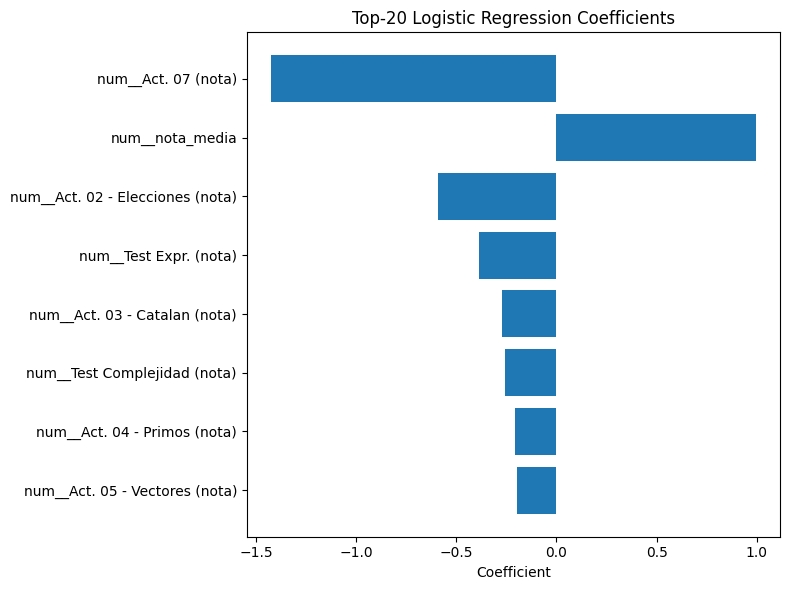

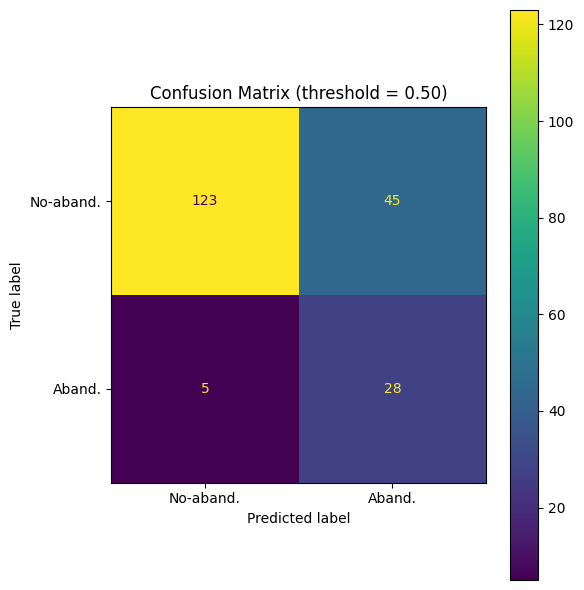

In [11]:
import joblib, os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- 1. Cargar modelo y datos ---------------------------------------------
pipeline = joblib.load(os.path.join(MODEL_PATH, "logreg.pkl"))
# Se asume que X, y están ya en memoria

y_prob = pipeline.predict_proba(X)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# --- 2. Coeficientes -------------------------------------------------------
feature_names = pipeline.named_steps["pre"].get_feature_names_out()
coef = pipeline.named_steps["clf"].coef_[0]
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef})
      .assign(abs_coef=lambda df: df.coef.abs())
      .sort_values("abs_coef", ascending=False)
)

print("LR Coefficients:")
display(coef_df[["feature", "coef"]])

# Gráfico Top‑20 coeficientes
plt.figure(figsize=(8,6))
plt.barh(coef_df.head(20)["feature"][::-1],
         coef_df.head(20)["coef"][::-1])
plt.xlabel("Coefficient")
plt.title("Top‑20 Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

# --- 4. Matriz de confusión (threshold = 0.5) -----------------------------
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No‑aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title("Confusion Matrix (threshold = 0.50)")
plt.tight_layout()
plt.show()

